# Working With HIRES Data
by Yannick Lecoeuche

## Introduction
In this tutorial we will show you how to open HIRES data, display images, and graph one-dimensional spectrums of the information kept in the image. We have supplied a stellar spectra and wavelength solution with the notebook, and we will begin by determining the minimum and maximum wavelengths represented in the spectrum and then attempting to recreate some sample graphs of the spectrum.

First, we must import the necessary programming components:

In [130]:
%matplotlib inline
import numpy as np
from astropy.io import fits as pf
import matplotlib
from matplotlib import pyplot as plt
import lmfit
from lmfit import minimize, Parameters, report_fit, fit_report
from IPython.display import Image

Among these imports includes the fits program, which allows us to easily read HIRES files in the format given, and pyplot, so we can represent the data given in our spectra. Next we will use the fits program to access our spectra (rj122.97.fits), and then dislay image information coded in the fits file:

In [131]:
HIRES_file = pf.open('rj122.97.fits')
HIRES_file.info()

Filename: rj122.97.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU     722   (4021, 16)   float32   


From the information we can see that this file contains a single image of type "PrimaryHDU". This is what we wanted to see, however, a problem becomes apparent upon further inspection. If you look in the "Dimensions" section, you may notice that the axes differ by a large factor. Attempting to plot an image with the x dimension so much larger than the y dimension gives an result like this:

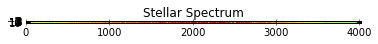

In [132]:
image = HIRES_file[0].data
plt.imshow(image)
plt.title('Stellar Spectrum')

The difference between the axes is indeed too large. We can't get much visual information from what appears to be a one dimensional line. To remedy this problem, we can add "aspect = 'auto'" as an argument in our plot function. This simply adjusts the output of the plot function so that the axes are sized similarly.

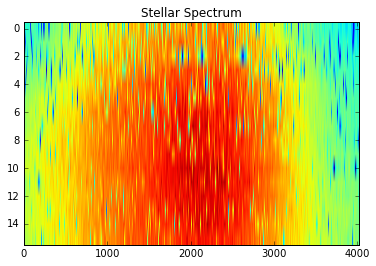

In [133]:
image = HIRES_file[0].data
plt.imshow(image, aspect = 'auto')
plt.title('Stellar Spectrum')

Much better! This is an image that may look more familiar to you. Now that we have our spectrum, we can analyze the information inside it most easily by turning parts of it into 1D brightness/wavelength graphs. In order to get our 1D graph from this 2D image, we need to select a single pixel line from the 16 avaliable in the y-axis (remember, we know that the dimensions are 16 by 4021 from looking at the file info). Let's plot line ten in the spectrum:

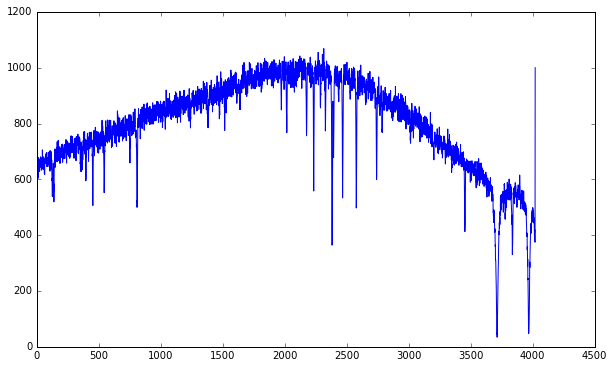

In [134]:
plt.figure(figsize = (10, 6))
plt.plot(image[10])

Terrific! There are some clearly visible dips and peaks in this spectrum. The x-axis, however, isn't much use to us when represented in pixels. We want to know which wavelengths the dips and peaks in our graph correspond to, so we need to match the pixels on the x-axis to the wavelengths by using the wavelength solution.

First we call up the wavelength solution, and assign the wavelength values to an array:

In [135]:
wavelength = pf.open('keck_rwav.fits')
wave_values = wavelength[0].data

Now that we have all our wavelength values, we can assign them to the x-axis and our spectrum values to the y-axis, and then graph them. While we're at it, we'll also label the x-axis with the proper units:

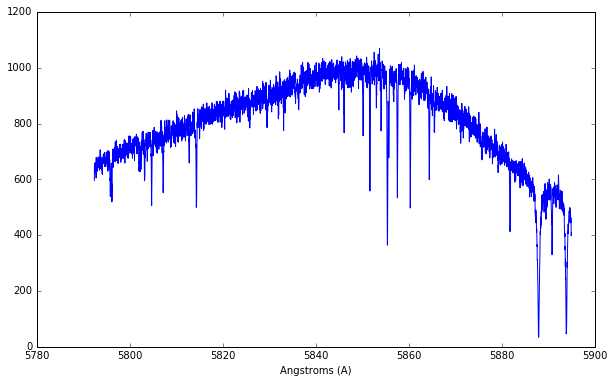

In [136]:
x = wave_values[10, 0:4016]
y = image[10, 0:4016]
plt.figure(figsize = (10,6))
plt.plot(x,y)
plt.xlabel('Angstroms (A)')

This looks almost like what we want! It seems we may have graphed too large of a wavelength range to pick out particular features. For an idea of what types of spectral features we hope to pick out, we can take a look at some sample graphs of this spectrum and attempt to recreate them ourselves.

![Example Spectrums](Image.png)

These graphs use much smaller wavelength ranges than we just did. Let's try and adjust our own range to match some of these images. It would prudent to first determine the total scope of wavelengths represented in our spectrum. We may find that some of the example graphs are out of our range. We can determine the lowest and highest wavelengths represented by looking at the first value on the 0th line and the last value on the 15th line (the is because the total amount is 16 and we index from 0):

In [137]:
print (wave_values[0, 0])
print (wave_values[15, 4020])

4976.64794645
6421.36429021


It looks like our range goes from 4976 Angstroms to 6421 Angstroms. So of the six example graphs, we can only attempt to replicate graphs 3 through 5. Let's start with 3. The boundaries of the third graph go from 5160 to 5210 Angstroms. By plugging test values into the wave_values array, we figure out that the 5160 and 5210 Angstrom marks correspond closest to the 1654th and 3924th pixels (respectively) on the second line.

In [138]:
print (wave_values[2, 1654])
print (wave_values[2, 3942])

5160.01086426
5210.0069462


Now that we have our boundaries, we can plug in those values and see how close the two graphs look in comparison:

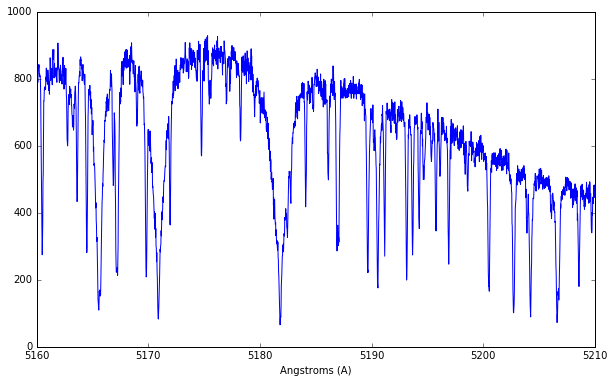

In [139]:
x = wave_values[2, 1654:3942]
y = image[2, 1654:3942]
plt.figure(figsize = (10,6))
plt.plot(x,y)
plt.xlabel('Angstroms (A)')

This looks incredibly similar other than the brightness measurement on the y-axis! Now we can replicate the 4th and 5th graphs. Since finding the appropriate boundaries has been explained, we will skip straight to the output:

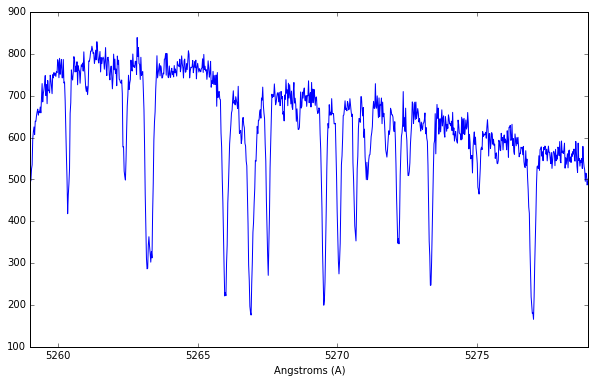

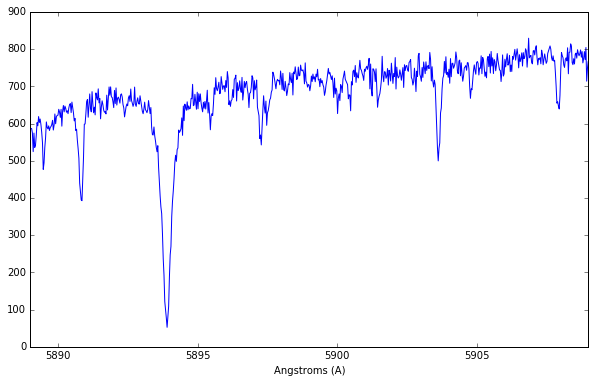

In [140]:
x = wave_values[3, 2664:3580]
y = image[2, 2664:3580]
plt.figure(figsize = (10,6))
plt.plot(x,y)
plt.axis([5259, 5279, 100, 900])
plt.xlabel('Angstroms (A)')

x = wave_values[11, 3:728]
y = image[11, 3:728]
plt.figure(figsize = (10,6))
plt.plot(x,y)
plt.axis([5889, 5909, 0, 900])
plt.xlabel('Angstroms (A)')

While our first and third graphs look quite similar to those given, the second does not.